## A simple model for demand and supply of publicly-provided services in a city

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import gaussian_process
from matplotlib import pyplot as plt 
from enum import Enum
import os.path
import geopy, geopy.distance
plt.rcParams['figure.figsize']= (20,14)

In [2]:
from cityItems import AgeGroup, ServiceArea, ServiceType, SummaryNorm # enum classes for the model

In [3]:
gaussKern = gaussian_process.kernels.RBF
get_random_pos = lambda n: list(map(geopy.Point, list(zip(np.round(np.random.uniform(45.40, 45.50, n), 5), 
                                np.round(np.random.uniform(9.1, 9.3, n), 5)))))

In [4]:
## ServiceUnit class
class ServiceUnit:
    def __init__(self, service, name='', position=geopy.Point(45.4641, 9.1919),
                 ageDiffusionIn={}, scaleIn=1, attributesIn={}):
        assert isinstance(position, geopy.Point), 'Position must be a geopy Point' 
        assert isinstance(service, ServiceType), 'Service must belong to the Eum'
        assert isinstance(name, str), 'Name must be a string'
        
        assert (np.isscalar(scaleIn)) & (scaleIn>0) , 'Scale must be a positive scalar'
        assert isinstance(attributesIn, dict), 'Attributes can be provided in a dict'
        
        self.name = name
        self.service = service
        
        # A ServiceType can have many sites, so each unit has its own. 
        # Moreover, a site is not uniquely assigned to a service
        self.site = position
        
        self.scale = scaleIn # store scale info
        self.attributes = attributesIn# dictionary
        
        # how the service availablity area varies for different age groups
        if ageDiffusionIn==None:
            self.ageDiffusion = {g: (1 + .005*np.round(np.random.normal(),2))*self.scale for g in AgeGroup.all()} 
        else:
            assert set(ageDiffusionIn.keys()) <= set(AgeGroup.all()), 'Diffusion keys should be AgeGroups'
            #assert all
            self.ageDiffusion = ageDiffusionIn
        self.kernel = {g: gaussKern(length_scale=l) for g, l in self.ageDiffusion.items()}
        
        
        
    def evaluate(self, targetPositions, ageGroup):
        assert all([isinstance(t, geopy.Point) for t in targetPositions]),'Geopy Points expected'
        
        # get distances
        distances = np.zeros(shape=(len(targetPositions),1))
        distances[:,0] = [geopy.distance.great_circle(x, self.site).km for x in targetPositions]
        
        # evaluate kernel to get level service score. If age group is not relevant to the service, return 0 as default
        if self.kernel.__contains__(ageGroup):
            score = self.kernel[ageGroup](distances, np.array([[0],]))
            # check conversion from tuple to nparray
            #targetPositions= np.array(targetPositions)
            #score2 = self.kernel[ageGroup](targetPositions, reshapedPos)
            #assert all(score-score2==0)
        else:
            score = np.zeros_like(targetPositions)
        return np.squeeze(score)
    
    @property
    def users(self): return list(self.propagation.keys())

In [213]:
### Supply modelling
def evaluate_services_at(positions, unitsList, outputServices= [t for t in ServiceType]):
    assert all([isinstance(t, geopy.Point) for t in positions]),'Geopy Points expected'
    # set all age groups as output default
    outputAgeGroups = AgeGroup.all()
    # initialise output
    outScores = {service: pd.DataFrame(np.zeros([len(positions), len(AgeGroup.all())]), 
                                 index=[tuple(t) for t in positions], columns=AgeGroup.all()) 
                 for service in outputServices}
    # loop over different services
    for thisServType in outputServices:
        serviceUnits = [u for u in unitsList if u.service == thisServType]
        if not serviceUnits:
            continue
        else:
            for thisAgeGroup in outputAgeGroups:
                unitValues = np.stack(list(map(lambda x: x.evaluate(positions, thisAgeGroup), serviceUnits)), axis=-1)
                # aggregate unit contributions according to the service type norm
                outScores[thisServType][thisAgeGroup] = thisServType.aggregate_units(unitValues)
            
    return outScores
        

In [214]:
test = [ServiceUnit(ServiceType.PoliceStation, 'Duomo', ageDiffusionIn=None), 
        ServiceUnit(ServiceType.PoliceStation, 'Ripamonti', 
                    position=geopy.Point(45.43, 9.201), ageDiffusionIn=None)]
evaluate_services_at(get_random_pos(4), test)


{<ServiceType.PoliceStation: (2, <ServiceArea.PublicSafety: 2>, <function SummaryNorm.<lambda> at 0x7f66a27e6ea0>)>:                           AgeGroup.Newborn  AgeGroup.ChildPrimary  \
 (45.43353, 9.1684, 0.0)       3.735251e-02           3.719358e-02   
 (45.44642, 9.13309, 0.0)      3.359673e-06           3.238275e-06   
 (45.41247, 9.24537, 0.0)      3.953392e-04           3.913450e-04   
 (45.43943, 9.2935, 0.0)       3.443366e-12           3.327574e-12   
 
                           AgeGroup.ChildMid  AgeGroup.ChildHigh  \
 (45.43353, 9.1684, 0.0)        3.627239e-02        3.560363e-02   
 (45.44642, 9.13309, 0.0)       2.945330e-06        4.112366e-06   
 (45.41247, 9.24537, 0.0)       3.686421e-04        3.526063e-04   
 (45.43943, 9.2935, 0.0)        2.720818e-12        2.342275e-12   
 
                           AgeGroup.Young  AgeGroup.Junior  AgeGroup.Senior  \
 (45.43353, 9.1684, 0.0)     3.712136e-02     3.708436e-02     3.578341e-02   
 (45.44642, 9.13309, 0.0)    3.9

In [7]:
class UnitFactory:
    def __init__(self, path):
        assert os.path.isfile(path), 'File "%s" not found' % path
        self.filepath = path
        self.rawData = []
        
    def load(self):
        self.rawData = pd.read_csv(self.filepath, sep=';', decimal=',')
        self.nUnits = self.rawData.shape[0]
        defaultLocationColumns = ['Lat', 'Long']
        if set(defaultLocationColumns).issubset(set(self.rawData.columns)):
            print('Location data found')
            # store geolocations as geopy Point
            locations = [geopy.Point(self.rawData.loc[i, defaultLocationColumns]) for i in range(self.nUnits)]
            propertData = self.rawData.drop(defaultLocationColumns, axis=1)
        else:
            propertData = self.rawData
            locations = []
            
        return propertData, locations

    @staticmethod
    def createLoader(serviceType, path):
        if serviceType == ServiceType.School:
            return SchoolFactory(path)

In [15]:
class SchoolFactory(UnitFactory):
    
    def __init__(self, path):
        super().__init__(path)
        
    def load(self):
        (propertData, locations) = super().load()
        
        nameCol = 'DENOMINAZIONESCUOLA'
        typeCol = 'ORDINESCUOLA'
        scaleCol = 'ALUNNI'
        
        typeAgeDict = {'SCUOLA PRIMARIA': {AgeGroup.ChildPrimary:1},
                      'SCUOLA SECONDARIA I GRADO': {AgeGroup.ChildMid:1},
                      'SCUOLA SECONDARIA II GRADO': {AgeGroup.ChildHigh:1},}
        
        schoolTypes = propertData[typeCol].unique()
        assert set(schoolTypes) <= set(typeAgeDict.keys()), 'Unrecognized types in input'
        
        # set the scale to be proportional to the square root of number of children
        scaleData = propertData[scaleCol]**.5
        scaleData = scaleData/scaleData.mean() * 1 #mean value is mapped to 1km
                
        unitList = []
                
        for scType in schoolTypes:
            bThisGroup = propertData[typeCol]==scType
            typeData = propertData[bThisGroup]
            typeLocations = [l for i,l in enumerate(locations) if bThisGroup[i]]

            for iUnit in range(typeData.shape[0]):
                rowData = typeData.iloc[iUnit,:]
                attrDict = {'level':scType}
                thisUnit = ServiceUnit(ServiceType.School, 
                        name=rowData[nameCol], 
                        position=typeLocations[iUnit], 
                        ageDiffusionIn=typeAgeDict[scType], 
                        scaleIn=rowData[scaleCol],
                        attributesIn=attrDict)
                unitList.append(thisUnit)
        
        return unitList

In [16]:
## Load scuole!
scuoleFile =  'final/milano_datiScuole.csv'
schoolLoader = UnitFactory.createLoader(ServiceType.School, scuoleFile)
schoolUnits = schoolLoader.load()

Location data found


In [225]:
## Plot tools
class unitPlotter:
    def __init__(self, unitList, gridSize=40):
        assert isinstance(unitList, list), 'List expected'
        assert all([isinstance(t, ServiceUnit) for t in unitList]), 'ServiceUnits expected in list'
        self.units = unitList
        self.gridSize = gridSize
        # precompute coordinate ranges
        self.latRange = (min(self.latitude), max(self.latitude))
        self.longRange = (min(self.longitude), max(self.longitude))
        
        # precompute plotting grid
        (self.xPlot, self.yPlot) = np.meshgrid(np.linspace(*self.latRange, gridSize),
                                               np.linspace(*self.longRange, gridSize),
                                        indexing='ij')
        # construct point objects with same shape
        self.plotPoints = np.empty_like(self.xPlot, dtype=object)
        for (i,j),_ in np.ndenumerate(self.plotPoints):
            self.plotPoints[i,j] = geopy.Point(self.xPlot[i,j], self.yPlot[i,j])
        
        self.serviceValues = {}
    
    @property
    def longitude(self):
        return [unit.site.longitude for unit in self.units]
    @property
    def latitude(self):
        return [unit.site.latitude for unit in self.units]
    @property
    def scale(self):
        scales = [unit.scale for unit in self.units]
        return scales
    
    
    def plot_locations(self):
        '''
        Plots the loaded ServiceUnits according to their locations and rescaling the relative sizes
        '''
        plotScales = self.scale/np.mean(self.scale)
        plt.figure()
        plt.scatter(self.latitude, self.longitude, s=plotScales)
        plt.axis('equal')
        plt.show()
        
    def compute_service_levels(self, servType):
        '''
        Evaluates on a grid the aggregate service level for the loaded ServiceUnits of a selected type.
        '''
        assert isinstance(servType, ServiceType), 'ServiceType expected in input'
        
        # extend internal cache with computed values
        self.serviceValues[servType] = evaluate_services_at(
            self.plotPoints.reshape(-1), self.units, [servType])[servType]
        return None
        
    def plot_service_levels(self, servType):
        '''
        Plots a contour graph of the results for each ageGroup.
        '''
        assert isinstance(servType, ServiceType), 'ServiceType expected in input'
        for ageGroup, valuesSeries in self.serviceValues[servType].items():
            valuesArray = np.vectorize(lambda p: valuesSeries[tuple(p)])(self.plotPoints)
            plt.figure()
            plt.title(ageGroup)
            CS = plt.contourf(plotter.xPlot, plotter.yPlot, valuesArray)
            cbar = plt.colorbar(CS)
            cbar.ax.set_ylabel('Service level')
            plt.show()
            
        return None
    
    
class zoneMapper:
    pass

In [228]:
plotter = unitPlotter(schoolUnits, gridSize=30)
plotter.compute_service_levels(ServiceType.School)

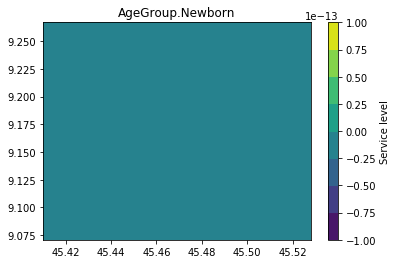

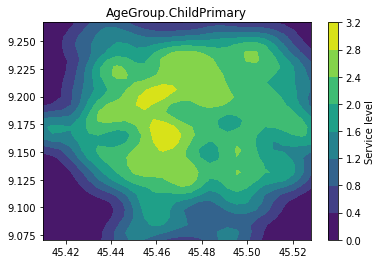

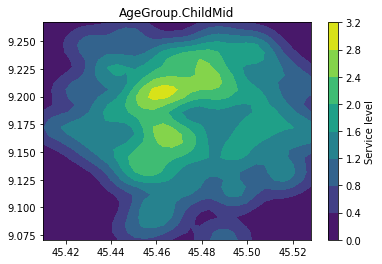

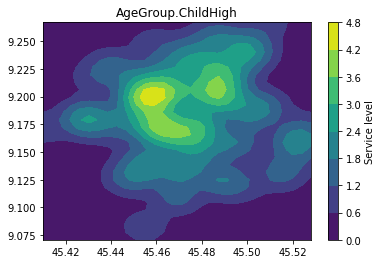

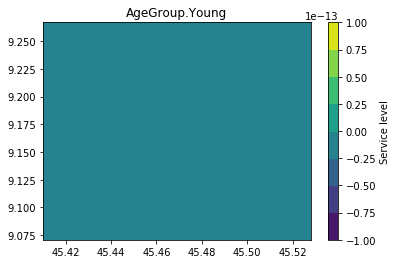

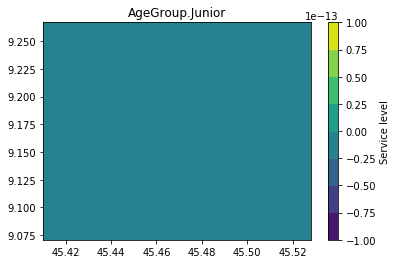

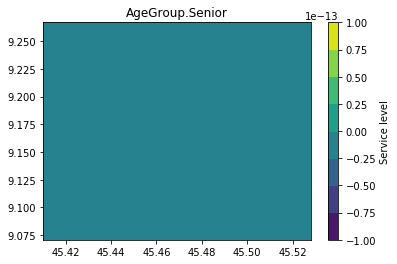

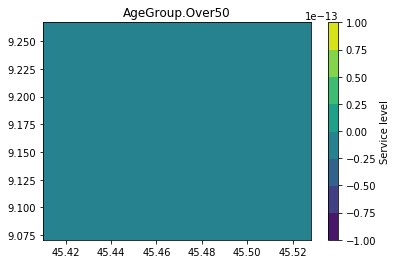

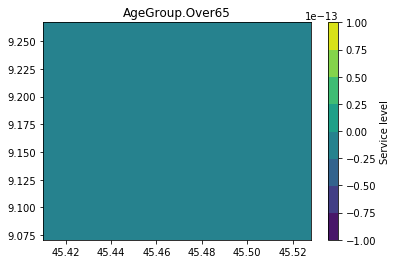

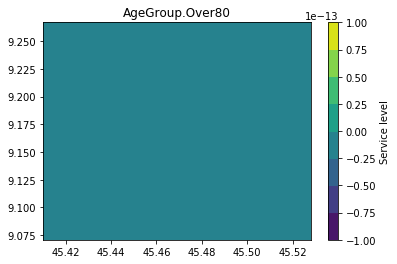

In [229]:
plotter.plot_service_levels(ServiceType.School)

In [13]:
### Demand modelling
class Household:
    def __init__(self, position=None, membersInput=None):
        # make defaults
        if not position: position = get_random_pos(1)
        if not membersInput: membersInput = {a: 1 for a in AgeGroup.all()}
        # expand input to all age group keys
        self.members = {a: membersInput.get(a, 0) for a in AgeGroup.all()}
        self.position = position
        self.export = pd.DataFrame(self.members, index=([self.position])) # precompute for speed

def evaluate_demand(householdList, outputServices= [t for t in ServiceType]):
    """ """
    # initialise output
    outDemand = dict()
    # consolidate positions. If two households share the same position, sum components.
    householdData = pd.concat([h.export for h in householdList])
    householdData['position'] = householdData.index 
    consolidated = householdData.groupby('position').sum()
    
    for thisServType in outputServices:
        outDemand[thisServType] = consolidated*thisServType.demandFactors
        
    return outDemand

In [14]:
hhList =  [Household() for i in range(40)]
evaluate_demand(hhList)

TypeError: unhashable type: 'Point'

In [ ]:
## Matching demand and supply
def get_satisfaction_indexes(householdList)